Following is the combined code for all the S5 figures

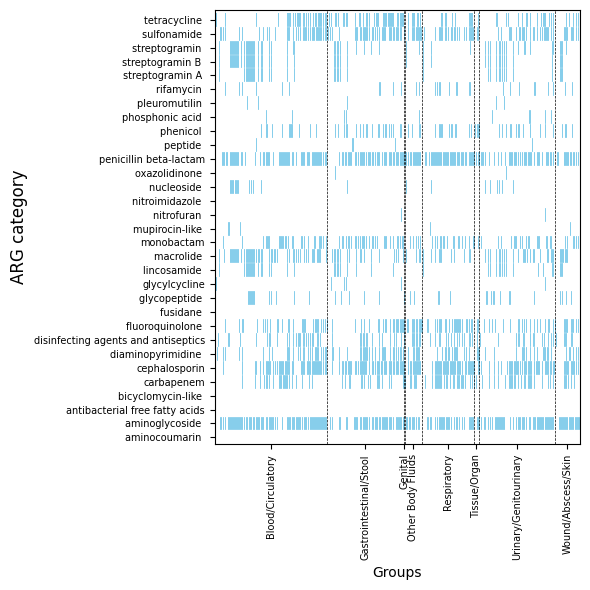

✅ Saved: /mnt/e/Figure_files/Fig4/Fig4/combined_group_heatmap.pdf


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and clean data
merged_path = 'S5_data.xlsx'
df = pd.read_excel(merged_path)
df.columns = df.columns.str.strip()

# Drop rows where Group is missing or is 'Miscellaneous/Unspecified Clinical'
df = df.dropna(subset=['Group'])
df = df[df['Group'].str.strip() != 'Miscellaneous/Unspecified Clinical']

# Sort by Group and then by Original_PCN
df = df.sort_values(by=['Group', 'Original_PCN'], ascending=[True, False], ignore_index=True)

# Keep SeqID and ARG matrix columns (assuming ARGs are in columns 1–32)
arg_matrix = df.iloc[:, 2:33].apply(pd.to_numeric, errors='coerce').fillna(0)

# Get Group info and unique list
group_labels = df['Group'].values
unique_groups = df['Group'].unique()

# Set up the figure
fig, ax1 = plt.subplots(figsize=(6, 6))

# Draw stacked bar heatmap
for i in range(arg_matrix.shape[1]):  # each ARG
    for j in range(arg_matrix.shape[0]):  # each plasmid
        if arg_matrix.iat[j, i] > 0:
            ax1.bar(j, 1, bottom=i, width=1.0, color='skyblue', align='center')

# Horizontal grid lines
for i in range(1, arg_matrix.shape[1]):
    ax1.axhline(i, color='white', linewidth=0.2)

# Clean ARG category labels
cleaned_labels = [label.replace("antibiotic", "") for label in arg_matrix.columns]
ax1.set_yticks(np.arange(arg_matrix.shape[1]) + 0.5)
ax1.set_yticklabels(cleaned_labels, fontsize=7)
ax1.set_xlim(-0.5, arg_matrix.shape[0] - 0.5)
ax1.set_ylim(0, arg_matrix.shape[1] + 0.2)
ax1.set_ylabel("ARG category", fontsize=12)

# Add vertical lines between groups
current_index = 0
for group in unique_groups:
    group_size = (group_labels == group).sum()
    if current_index != 0:
        ax1.axvline(current_index - 0.5, color='black', linestyle='--', linewidth=0.5)
    current_index += group_size

# Add group names on x-axis using center points
group_positions = []
group_ticks = []
current_index = 0
for group in unique_groups:
    group_size = (group_labels == group).sum()
    center = current_index + group_size / 2 - 0.5
    group_positions.append(center)
    group_ticks.append(group)
    current_index += group_size

ax1.set_xticks(group_positions)
ax1.set_xticklabels(group_ticks, rotation=90, fontsize=7)
ax1.set_xlabel("Groups", fontsize=10)

# Save and show
output_path = 'S5_A.pdf'
plt.tight_layout()
plt.savefig(output_path, format='pdf', dpi=1200)
plt.show()
print(f"✅ Saved: {output_path}")


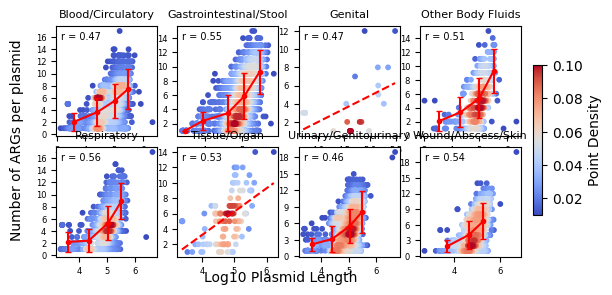

✅ Final plot saved to: /mnt/e/Figure_files/Fig4/Fig4/ARG_vs_Length_EqualWidth_Mixed.pdf


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr, linregress
import matplotlib.ticker as mticker
import os

# Load and clean data
merged_path = 'S5_data.xlsx'
df = pd.read_excel(merged_path)
df.columns = df.columns.str.strip()

# Filter valid groups
df = df.dropna(subset=['Group', 'Plasmid_Length'])
df = df[~df['Group'].str.strip().isin(['Miscellaneous/Unspecified Clinical'])]

# Compute ARG count and log plasmid length
arg_matrix = df.iloc[:, 2:33].apply(pd.to_numeric, errors='coerce').fillna(0)
df['Num_ARGs'] = (arg_matrix > 0).sum(axis=1)
df['Log10_Length'] = np.log10(np.where(df['Plasmid_Length'] <= 0, np.nan, df['Plasmid_Length']))

# Setup plot layout
groups = sorted(df['Group'].unique())
cols = 4
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(6, 3), squeeze=False)
fig.subplots_adjust(hspace=0.1, wspace=0.2)


# Parameters
num_bins = 5
threshold_points = 150
min_points_per_bin = 5

# Plot each group
for idx, group in enumerate(groups[:rows * cols]):
    row, col = divmod(idx, cols)
    ax = axes[row][col]
    group_df = df[df['Group'] == group]
    x = group_df['Log10_Length'].values
    y = group_df['Num_ARGs'].values

    if len(x) < 2:
        continue

    # KDE for point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx_sort = z.argsort()
    x, y, z = x[idx_sort], y[idx_sort], z[idx_sort]

    # Plot scatter
    ax.scatter(x, y, c=z, s=10, cmap='coolwarm')

    if len(x) >= threshold_points:
        x_range = (np.floor(x.min()), np.ceil(x.max()))
        bins = np.linspace(x_range[0], x_range[1], num_bins + 1)
        bin_indices = np.digitize(x, bins)

        binned_y_means, binned_y_stds, bin_centers = [], [], []
        for i in range(1, num_bins + 1):
            mask = bin_indices == i
            if np.sum(mask) >= min_points_per_bin:
                binned_y_means.append(np.mean(y[mask]))
                binned_y_stds.append(np.std(y[mask]))
                bin_centers.append(np.mean(x[mask]))
            else:
                binned_y_means.append(np.nan)
                binned_y_stds.append(np.nan)
                bin_centers.append(np.mean(x[mask]) if np.any(mask) else np.nan)

        # Plot binned error bars
        valid = ~np.isnan(binned_y_means)
        ax.errorbar(np.array(bin_centers)[valid], np.array(binned_y_means)[valid],
                    yerr=np.array(binned_y_stds)[valid],
                    fmt='ro-', capsize=2, markersize=3)

    else:
        # Linear regression line for small groups
        slope, intercept, _, _, _ = linregress(x, y)
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r--', linewidth=1.5)

    # Pearson correlation
    r, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes,
            fontsize=7, verticalalignment='top')

    ax.set_title(f"{group}", fontsize=8)
    ax.tick_params(labelsize=6)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Hide unused axes
for i in range(len(groups), rows * cols):
    row, col = divmod(i, cols)
    axes[row][col].set_visible(False)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
norm = plt.Normalize(vmin=0.01, vmax=0.1)
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), cax=cbar_ax)
cb.set_label('Point Density')

# Shared axis labels
fig.text(0.5, 0.04, 'Log10 Plasmid Length', ha='center', va='center', fontsize=10)
fig.text(0.06, 0.5, 'Number of ARGs per plasmid', ha='center', va='center', rotation='vertical', fontsize=10)

# Save and show
output_path = 'S5_C.pdf'
plt.savefig(output_path, format='pdf', dpi=1200)
plt.show()

print(f"✅ Final plot saved to: {output_path}")


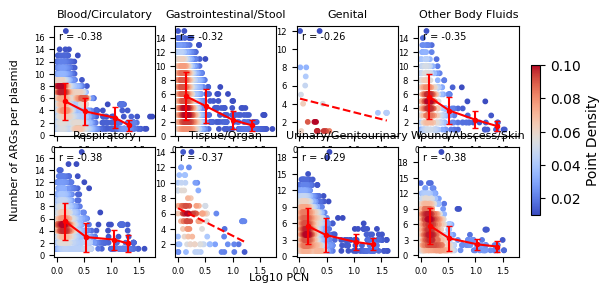

✅ Final plot saved to: /mnt/e/Figure_files/Fig4/Fig4/ARG_vs_PCN_MixedBinning_AdjustedXrange.pdf


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr, linregress
import matplotlib.ticker as mticker
import os

# Load and clean data
merged_path = 'S5_data.xlsx'
df = pd.read_excel(merged_path)
df.columns = df.columns.str.strip()

# Filter and prepare data
df = df.dropna(subset=['Group', 'Original_PCN'])
df = df[df['Group'].str.strip() != 'Miscellaneous/Unspecified Clinical']

# Compute features
arg_matrix = df.iloc[:, 2:33].apply(pd.to_numeric, errors='coerce').fillna(0)
df['Num_ARGs'] = (arg_matrix > 0).sum(axis=1)
df['Log10_PCN'] = np.log10(np.where(df['Original_PCN'] <= 0, np.nan, df['Original_PCN']))

# Plot settings
groups = sorted(df['Group'].unique())
cols, rows = 4, 2
fig, axes = plt.subplots(rows, cols, figsize=(6, 3), squeeze=False)
fig.subplots_adjust(hspace=0.1, wspace=0.2)


# Binning parameters
x_min, x_max = 0, 1.6
bins = np.linspace(x_min, x_max, 4 + 1)  # 4 equal-width bins
num_bins = len(bins) - 1
min_points = 5
threshold_points = 150

# Plot each group
for idx, group in enumerate(groups[:rows * cols]):
    row, col = divmod(idx, cols)
    ax = axes[row][col]
    group_df = df[df['Group'] == group]
    x = group_df['Log10_PCN'].values
    y = group_df['Num_ARGs'].values

    x = np.clip(x, 0, None)  # Ensure no negative values

    # KDE density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx_sort = z.argsort()
    x, y, z = x[idx_sort], y[idx_sort], z[idx_sort]

    ax.scatter(x, y, c=z, s=10, cmap='coolwarm')

    if len(x) >= threshold_points:
        # Equal-width binning
        bin_indices = np.digitize(x, bins)
        binned_y_means, binned_y_stds, bin_centers = [], [], []

        for i in range(1, num_bins + 1):
            mask = bin_indices == i
            if np.sum(mask) >= min_points:
                binned_y_means.append(np.mean(y[mask]))
                binned_y_stds.append(np.std(y[mask]))
                bin_centers.append(np.mean(x[mask]))
            else:
                binned_y_means.append(np.nan)
                binned_y_stds.append(np.nan)
                bin_centers.append(np.mean(x[mask]) if np.any(mask) else np.nan)

        valid = ~np.isnan(binned_y_means)
        ax.errorbar(np.array(bin_centers)[valid], np.array(binned_y_means)[valid],
                    yerr=np.array(binned_y_stds)[valid], fmt='ro-', capsize=2, markersize=3)
    else:
        # Linear regression line
        if len(x) > 1:
            slope, intercept, _, _, _ = linregress(x, y)
            x_fit = np.linspace(np.min(x), np.max(x), 100)
            y_fit = slope * x_fit + intercept
            ax.plot(x_fit, y_fit, 'r--', linewidth=1.5)

    # Pearson correlation
    r, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes,
            fontsize=7, verticalalignment='top')

    ax.set_title(f"{group}", fontsize=8)
    ax.tick_params(labelsize=6)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-0.05, 1.8)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Hide unused axes
for i in range(len(groups), rows * cols):
    row, col = divmod(i, cols)
    axes[row][col].set_visible(False)

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
norm = plt.Normalize(vmin=0.01, vmax=0.1)
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), cax=cbar_ax)
cb.set_label('Point Density')

# Shared axis labels
fig.text(0.5, 0.04, 'Log10 PCN', ha='center', va='center', fontsize=8)
fig.text(0.06, 0.5, 'Number of ARGs per plasmid', ha='center', va='center', rotation='vertical', fontsize=8)

# Save and show
output_path = 'S5_D.pdf'
plt.savefig(output_path, format='pdf', dpi=1200)
plt.show()

print(f"✅ Final plot saved to: {output_path}")


ARG columns being analyzed: ['aminocoumarin antibiotic', 'aminoglycoside antibiotic', 'antibacterial free fatty acids', 'bicyclomycin-like antibiotic', 'carbapenem', 'cephalosporin', 'diaminopyrimidine antibiotic', 'disinfecting agents and antiseptics', 'fluoroquinolone antibiotic', 'fusidane antibiotic', 'glycopeptide antibiotic', 'glycylcycline', 'lincosamide antibiotic', 'macrolide antibiotic', 'monobactam', 'mupirocin-like antibiotic', 'nitrofuran antibiotic', 'nitroimidazole antibiotic', 'nucleoside antibiotic', 'oxazolidinone antibiotic', 'penicillin beta-lactam', 'peptide antibiotic', 'phenicol antibiotic', 'phosphonic acid antibiotic', 'pleuromutilin antibiotic', 'rifamycin antibiotic', 'streptogramin A antibiotic', 'streptogramin B antibiotic', 'streptogramin antibiotic', 'sulfonamide antibiotic', 'tetracycline antibiotic']

Intermediate data saved to: /mnt/e/Figure_files/Fig4/Fig4/ARG_prevalence_calculations.xlsx


/tmp/ipykernel_525172/1676540723.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=90, fontsize=10)


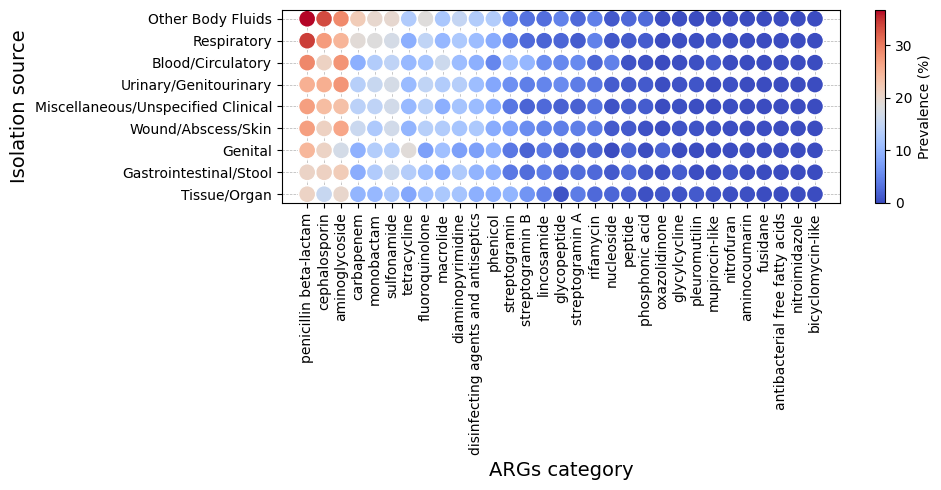

✅ Plot saved to: /mnt/e/Figure_files/Fig4/Fig4/ARG_prevalence_plot_updated.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# 1. Load and prepare data
df = pd.read_excel('S5_data.xlsx')
df.columns = df.columns.str.strip()

# 2. Select ARG columns
arg_columns = df.columns[2:33]  # Adjust if necessary
print("ARG columns being analyzed:", arg_columns.tolist())

# 3. Sample counts for each group
sample_counts = {
    'Miscellaneous/Unspecified Clinical': 10716,
    'Blood/Circulatory': 5380,
    'Gastrointestinal/Stool': 4797,
    'Urinary/Genitourinary': 3801,
    'Respiratory': 2456,
    'Wound/Abscess/Skin': 1248,
    'Other Body Fluids': 725,
    'Tissue/Organ': 314,
    'Genital': 53
}

# 4. Calculate prevalence
results = []
for group_name, group_df in df.groupby('Group'):
    total_samples = sample_counts[group_name]
    for arg in arg_columns:
        arg_count = group_df[arg].sum()
        prevalence = (arg_count / total_samples) * 100
        results.append({
            'Group': group_name,
            'ARG': arg,
            'Prevalence': prevalence,
            'Count': arg_count,
            'Total_Samples': total_samples
        })

plot_data = pd.DataFrame(results)

# Save intermediate data
intermediate_path = 'ARG_prevalence_calculations.xlsx'
plot_data.to_excel(intermediate_path, index=False)
print(f"\nIntermediate data saved to: {intermediate_path}")

# 5. Sort for better visualization
plot_data_sorted = plot_data.sort_values('Prevalence', ascending=False)

# 6. Create bubble plot using fixed size and color for prevalence
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(
    data=plot_data_sorted,
    x='ARG',
    y='Group',
    hue='Prevalence',
    palette='coolwarm',
    s=150,  # fixed bubble size
    legend=False,
    alpha=1
)

# 7. Format x-axis labels
xticklabels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [label.replace(' antibiotic', '') for label in xticklabels]
ax.set_xticklabels(new_labels, rotation=90, fontsize=10)

# 8. Grid and aesthetics
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.xlabel('ARGs category', fontsize=14)
plt.ylabel('Isolation source', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# 9. Add continuous colorbar
norm = Normalize(vmin=plot_data_sorted['Prevalence'].min(), vmax=plot_data_sorted['Prevalence'].max())
sm = cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Prevalence (%)')

# 10. Save and show plot
plt.tight_layout()
plot_path = 'S5_B.pdf'
plt.savefig(plot_path, dpi=1200, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to: {plot_path}")
